# Práctica entregable: Feature Selection aplicada al dataset *Housing* con un problema de regresión

Para este problema, utilizaremos el dataset *Housing*, estudiado anteriormente en la práctica P7 de la asignatura. Recogeremos exactamente el último tratamiento realizado, en el que se le aplica un escalado *MinMaxScaler* entre *0* y *1* y una transformación avanzada *PowerTransformer*.

Veamos los resultados obtenidos en la práctica para este procesado aplicando un modelo SVR de hiperparámetros por defecto.

In [1]:
# example of power transform input and output variables for regression.
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)

# prepare the model with input scaling and power transform
steps = list()
#steps.append(('scale', MinMaxScaler()))
steps.append(('scale', MinMaxScaler(feature_range=(1e-5, 1))))
steps.append(('power', PowerTransformer()))
steps.append(('model', svm.SVR()))
#steps.append(('model', HuberRegressor()))
pipeline = Pipeline(steps=steps)

# prepare the model with target scaling
model_target_regressor = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_target_regressor, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert scores to positive
scores = absolute(scores)
# summarize the result
s_mean = mean(scores)
print('Mean MAE: %.3f' % (s_mean))

(506, 13) (506,)
Mean MAE: 2.209


## Selección de Características mediante Coeficientes de Correlación

Veamos el orden de las variables en base a los coeficientes de correlación mediante la función *f_regression()*.

In [2]:
# Example of calculating correlation statistics for all input variables.
# example of correlation feature selection for numerical data
from numpy import empty
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all') #Pearson's correlation (only positive values) ¿k=10?
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs  #return fs with scores

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)
# split into train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
corr = empty((X.shape[1],2))
for i in range(len(fs.scores_)):
    corr[i,0] = i
    corr[i,1] = fs.scores_[i]
    print('Feature %d: %f' % (i, fs.scores_[i]))
print()
print(corr[corr[:, 1].argsort()[::-1]][:,0])

    #10 valores interesantes, el resto irrelevantes

(506, 13) (506,)
Feature 0: 73.362968
Feature 1: 71.032551
Feature 2: 132.606905
Feature 3: 10.055319
Feature 4: 102.055325
Feature 5: 329.164062
Feature 6: 82.965262
Feature 7: 34.251355
Feature 8: 73.543625
Feature 9: 110.524655
Feature 10: 152.853099
Feature 11: 48.938266
Feature 12: 490.397465

[12.  5. 10.  2.  9.  4.  6.  8.  0.  1. 11.  7.  3.]


Visualicemos claramente los resultados.

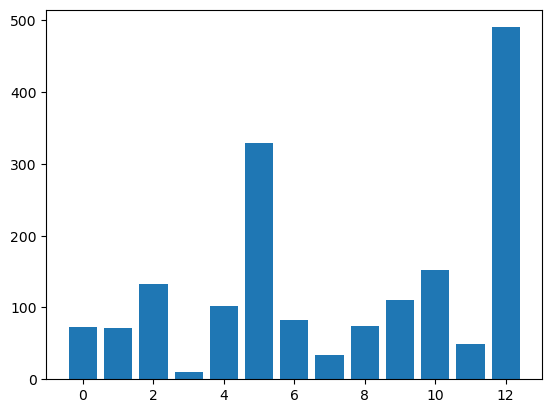

In [3]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Selección de Características mediante Mutual Information

Veamos el orden de las variables en base al Mutual Information mediante la función *mutual_info_regression()*:

In [4]:
# Example of applying mutual information feature selection and summarizing the selected features.
# example of mutual information feature selection for numerical input data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all') #score_func=mutual_info_regression
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
corr = empty((X.shape[1],2))
for i in range(len(fs.scores_)):
    corr[i,0] = i
    corr[i,1] = fs.scores_[i]
    print('Feature %d: %f' % (i, fs.scores_[i]))
print()
print(corr[corr[:, 1].argsort()[::-1]][:,0])

(506, 13) (506,)
Feature 0: 0.310451
Feature 1: 0.185942
Feature 2: 0.517256
Feature 3: 0.014123
Feature 4: 0.443175
Feature 5: 0.487332
Feature 6: 0.343970
Feature 7: 0.291080
Feature 8: 0.194301
Feature 9: 0.334058
Feature 10: 0.450730
Feature 11: 0.177433
Feature 12: 0.690850

[12.  2.  5. 10.  4.  6.  9.  0.  7.  8.  1. 11.  3.]


Visualicemos claramente los resultados.

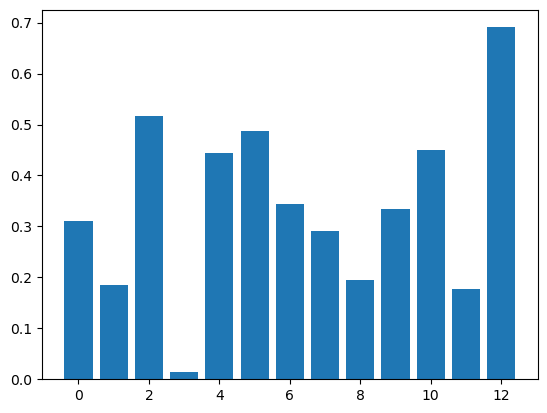

In [5]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Resultados de la aplicación de la Selección de Características

### Cálculo del MAE base

Para poder comprobar la mejora (o la no pérdida) en los resultados obtenidos, calculemos el MAE base para el modelo aplicado al dataset con el procesamiento básico identificado en la práctica *P7*. Para ello, dejamos que se utilicen todas las variables del dataset.

In [6]:
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# prepare the model with input scaling and power transform
steps = list()
#steps.append(('scale', MinMaxScaler()))
steps.append(('scale', MinMaxScaler(feature_range=(1e-5, 1))))
steps.append(('power', PowerTransformer()))
steps.append(('model', svm.SVR()))
#steps.append(('model', HuberRegressor()))
pipeline = Pipeline(steps=steps)

# prepare the model with target scaling
model_target_regressor = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
pipeline.fit(X_train, y_train)

# evaluate predictions
yhat = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(506, 13) (506,)
MAE: 3.519


### Cálculo del MAE con Selección de Características mediante Coeficientes de Correlación

Ahora, calculemos el MAE para la aplicación del mismo modelo aplicado sobre los datos con el mismo procesamiento sobre un número inferior de variables seleccionadas mediante los coeficientes de correlación. Por ejemplo, vemos que utilizando solo 5 variables disminuimos considerablemente la complejidad del modelo y aumentamos la precisión.

In [7]:
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=5)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# feature selection
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)

# prepare the model with input scaling and power transform
steps = list()
#steps.append(('scale', MinMaxScaler()))
steps.append(('scale', MinMaxScaler(feature_range=(1e-5, 1))))
steps.append(('power', PowerTransformer()))
steps.append(('model', svm.SVR()))
#steps.append(('model', HuberRegressor()))
pipeline = Pipeline(steps=steps)

# prepare the model with target scaling
model_target_regressor = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
pipeline.fit(X_train_fs, y_train)

# evaluate predictions
yhat = pipeline.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(506, 13) (506,)
MAE: 3.334


### Cálculo del MAE con Selección de Características mediante Mutual Information

Ahora, calculemos el MAE para la aplicación del mismo modelo aplicado sobre los datos con el mismo procesamiento sobre un número inferior de variables seleccionadas mediante los valores de información mutua. Por ejemplo, vemos que utilizando 6 variables también disminuimos la complejidad del modelo y seguimos aumentando la precisión.

In [8]:
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=6)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# feature selection
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)

# prepare the model with input scaling and power transform
steps = list()
#steps.append(('scale', MinMaxScaler()))
steps.append(('scale', MinMaxScaler(feature_range=(1e-5, 1))))
steps.append(('power', PowerTransformer()))
steps.append(('model', svm.SVR()))
#steps.append(('model', HuberRegressor()))
pipeline = Pipeline(steps=steps)

# prepare the model with target scaling
model_target_regressor = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
pipeline.fit(X_train_fs, y_train)

# evaluate predictions
yhat = pipeline.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(506, 13) (506,)
MAE: 3.392


## Resumen de resultados

In [9]:
from pandas import DataFrame
results = DataFrame(columns=['FSmethod', 'k', 'MAE'])

In [10]:
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from pandas import read_csv
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(func, k, X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=func, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs

FSmethods = [f_regression, mutual_info_regression]
FSmethods_names = ['Correlación','Mutual Information']
k_values = list(range(1,14))

# load data 
dataframe = read_csv('housing.csv', header=None)
# split into inputs and outputs
last_ix = len(dataframe.columns) - 1
X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
print(X.shape, y.shape)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# prepare the model with input scaling and power transform
steps = list()
#steps.append(('scale', MinMaxScaler()))
steps.append(('scale', MinMaxScaler(feature_range=(1e-5, 1))))
steps.append(('power', PowerTransformer()))
steps.append(('model', svm.SVR()))
#steps.append(('model', HuberRegressor()))
pipeline = Pipeline(steps=steps)

for i,FSmethod in enumerate(FSmethods):
    for k in k_values:
        # feature selection
        X_train_fs, X_test_fs = select_features(FSmethod, k, X_train, y_train, X_test)

        # prepare the model with target scaling
        model_target_regressor = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
        pipeline.fit(X_train_fs, y_train)

        # evaluate predictions
        yhat = pipeline.predict(X_test_fs)
        mae = mean_absolute_error(y_test, yhat)
        
        results.loc[len(results.index)] = {'FSmethod': FSmethods_names[i], 
                    'k': k, 
                    'MAE': mae}
        
        # print('MAE (%s con k=%i): %.3f' % (FSmethods_names[i], k, mae))

(506, 13) (506,)


In [11]:
results.sort_values('MAE', ascending=True).head(5)

,FSmethod,k,MAE
22,Mutual Information,10,3.295261
21,Mutual Information,9,3.303136
4,Correlación,5,3.333810
8,Correlación,9,3.368152
19,Mutual Information,7,3.381178


Aunque para escoger el mejor método de Feature Selection deberíamos haber utilizado el conjunto de validación (con un CrossValidation adecuado), estos resultados nos permiten hacernos una idea de qué resultados se obtienen con los distintos métodos para este dataset con la partición realizada.

Aunque depende de lo que busquemos en cada problema, considero que la selección de 5 variables realizada mediante los coeficientes de correlación nos aporta el "mejor" resultado.